# Телеком — задача проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Описание полей данных:**
* `BeginDate` – дата начала пользования услугами,
* `EndDate` – дата окончания пользования услугами,
* `Type` – тип оплаты: ежемесячный, годовой и тд,
* `PaperlessBilling` – безналичный расчет,
* `PaymentMethod` – способ оплаты,
* `MonthlyCharges` – ежемесячные траты на услуги,
* `TotalCharges` – всего потрачено денег на услуги
* `Dependents` – наличие иждивенцев
* `Senior Citizen` – наличие пенсионного статуса по возрасту
* `Partner` – наличие супруга(и)
* `MultipleLines` – наличие возможности ведения параллельных линий во время звонка


# Содержание - онЖеПлан - онЖеДекопозицияЗадачи

1. [Иследовательский анализ данных](#eda)
2. [Предобработка данных](#preprocessing)
    * [Объединение данных](#concat)
    * [Замена типов данных](#type)
    * [Обработка пропусков и дубликатов](#nan)
    * [Создание дополнительных признаков](#adds)
    * [Очистка от выбросов](#outliers)
    * [Кодирование категориальных признаков](#ohe)
    * [Масштабирование данных](#scale)
    * [Формирование target-признака](#target)
    * [train-test разбиение](#division)
    * [Балансировка классов](#balanced)
3. [Моделирование](#ml)
    * [Выбор моделей и Подбор гиперпараметров](#model)
    * [Сравнение моделей](#cmp)  
    * [Тестирование лучшей модели](#test)
4. [Выводы и рекомендации](#conclusion)

<a id="eda"></a>
## Иследовательский анализ данных 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score,f1_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
PATH = '/datasets/final_provider/'
RANDOM_STATE = 80822

In [3]:
contract = pd.read_csv(PATH + 'contract.csv')
personal = pd.read_csv(PATH + 'personal.csv')
internet = pd.read_csv(PATH + 'internet.csv')
phone = pd.read_csv(PATH + 'phone.csv')

In [4]:
def explore_data(df):
    display(
        "Сводная информация:", df.info(),
        "10 строк:", df.head(10),
        "Столбцы:", df.columns,
        "Числовое описание:", df.describe(),
        "Сумма пропусков:", df.isna().sum(),
        "Доля пропусков:", df.isna().mean(),
        "Явные дубликаты:", df.duplicated().sum(),
        #"Корреляция:", df.corr(),
        #sns.heatmap(df.corr())
    )
    

In [5]:
explore_data(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


'Сводная информация:'

None

'10 строк:'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


'Столбцы:'

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

'Числовое описание:'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


'Сумма пропусков:'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

'Доля пропусков:'

customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

'Явные дубликаты:'

0

<AxesSubplot:title={'center':'График прихода клиентов'}>

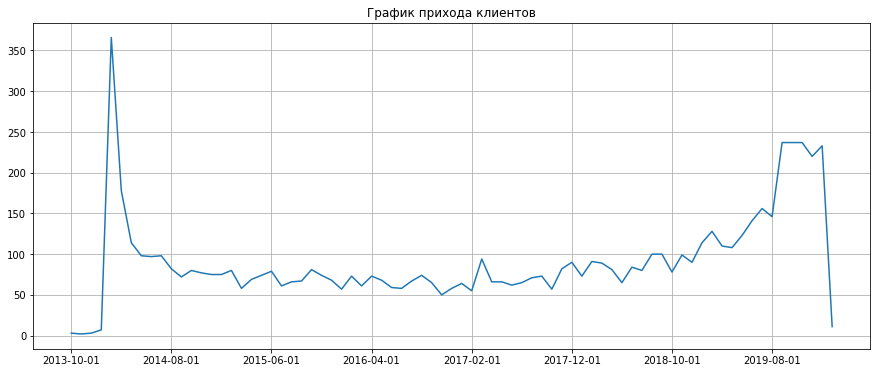

In [6]:
contract.BeginDate.value_counts().sort_index().plot(grid=True, figsize=(15,6), title='График прихода клиентов')

<AxesSubplot:title={'center':'График оттока клиентов'}>

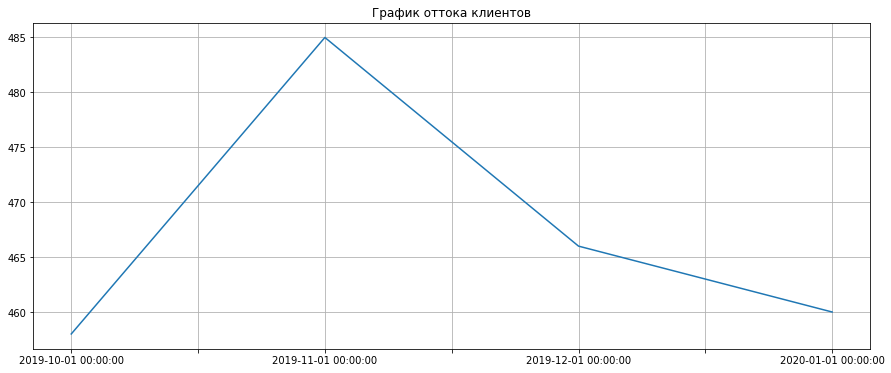

In [7]:
contract[contract.EndDate != 'No'].EndDate.value_counts().sort_index().plot(grid=True, figsize=(15,6), title='График оттока клиентов')

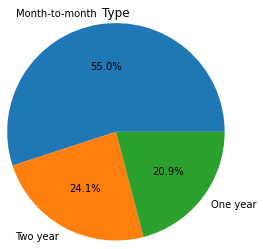

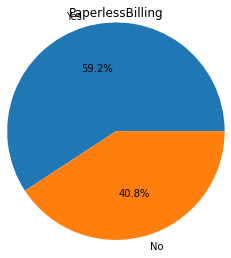

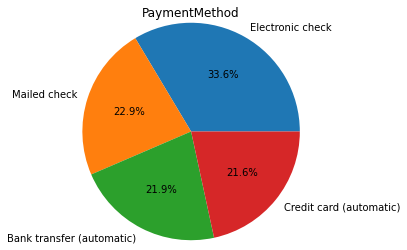

In [8]:
for column in ['Type','PaperlessBilling','PaymentMethod']:
    column_vc = contract[column].value_counts()
    plt.pie(column_vc.values, labels=column_vc.index, autopct='%1.1f%%', radius=1.25)
    plt.title(column)
    plt.show()

TotalCharges необходимо перевести в float, BeginDate и EndDate перевести в дату, можно расчитать средний срок ухода клиента на основе EndDate создать target, пропусков и явных дубликатов не обнаружено

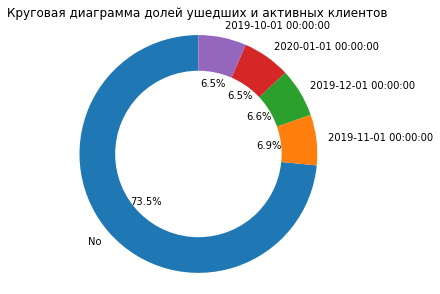

In [9]:
end_vc = contract.EndDate.value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(end_vc.values, labels=end_vc.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title("Круговая диаграмма долей ушедших и активных клиентов")
plt.show()

По состоянию на 1 февраля 2020 Оператор потерял 26.5% клиентсой базы. Клиенты начали уходить в 4 квартала 2019 года 

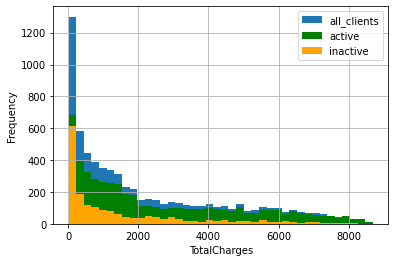

In [10]:
contract.TotalCharges = pd.to_numeric(contract.TotalCharges, errors='coerce')
contract.TotalCharges.hist(bins=40, label='all_clients' )
contract.query('EndDate =="No"').TotalCharges.hist(bins=40, color='green', label='active')
contract.query('EndDate !="No"').TotalCharges.hist(bins=40, color='orange', label='inactive')
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')
plt.legend()
plt.show()

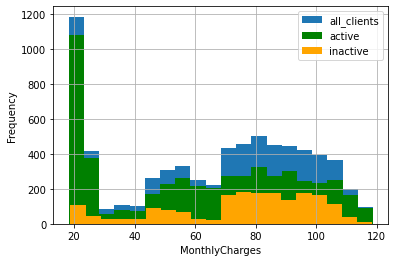

In [11]:
contract.MonthlyCharges.hist(bins=20, label='all_clients' )
contract.query('EndDate =="No"').MonthlyCharges.hist(bins=20, color='green', label='active')
contract.query('EndDate !="No"').MonthlyCharges.hist(bins=20, color='orange', label='inactive')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Большая часть ушедших клиентов платила в диапазоне 70 - 110, в то же время у действующих клиентов максимум наблюдается до 25

In [12]:
display(contract.describe(),
    contract.query('EndDate =="No"').describe(),
    contract.query('EndDate !="No"').describe())

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


,MonthlyCharges,TotalCharges
count,5174.000000,5163.000000
mean,61.265124,2555.344141
std,31.092648,2329.456984
min,18.250000,18.800000
25%,25.100000,577.825000
50%,64.425000,1683.600000
75%,88.400000,4264.125000
max,118.750000,8672.450000


,MonthlyCharges,TotalCharges
count,1869.000000,1869.000000
mean,74.441332,1531.796094
std,24.666053,1890.822994
min,18.850000,18.850000
25%,56.150000,134.500000
50%,79.650000,703.550000
75%,94.200000,2331.300000
max,118.350000,8684.800000


Средняя месячные и годовые затраты у ушедших клиентов выше

<AxesSubplot:>

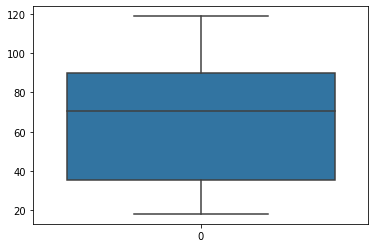

In [13]:
sns.boxplot(data=contract['MonthlyCharges'],  orient='v' )

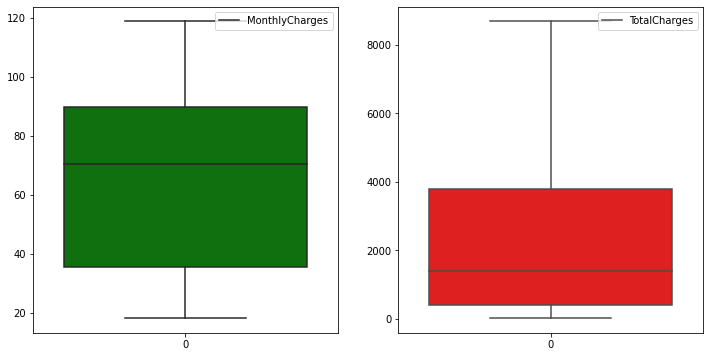

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.boxplot(data=contract['MonthlyCharges'],  orient='v' , ax=ax[0], color='green')
ax[0].legend(['MonthlyCharges'], loc=1)
sns.boxplot(data=contract['TotalCharges'],  orient='v' , ax=ax[1], color='r')
ax[1].legend(['TotalCharges'], loc=1)
plt.show()

Аномальных значений в `MonthlyCharges` и `TotalCharges` не обнаружено

In [15]:
explore_data(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'Сводная информация:'

None

'10 строк:'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


'Столбцы:'

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

'Числовое описание:'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


'Сумма пропусков:'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'Доля пропусков:'

customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

'Явные дубликаты:'

0

 пропусков и явных дубликатов не обнаружено

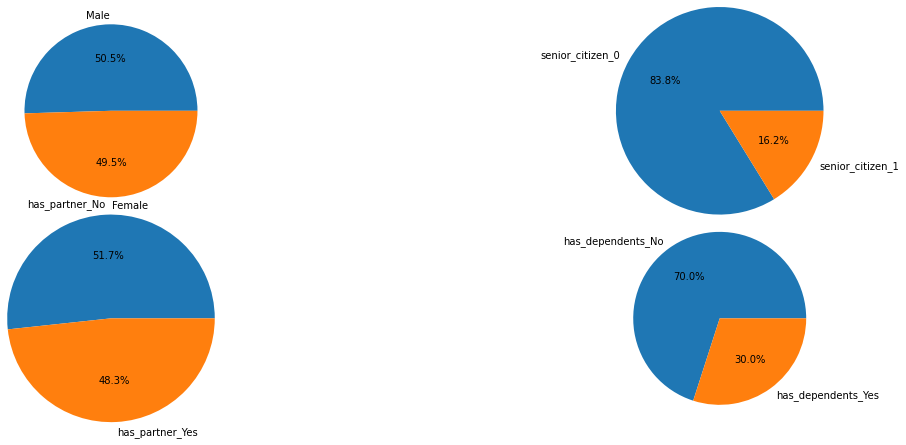

In [16]:
personal_vc = personal['gender'].value_counts()
senior_sitizen_vc = personal['SeniorCitizen'].value_counts()
partner_vc = personal['Partner'].value_counts()
dependents_vc = personal['Dependents'].value_counts()

fig, ax = plt.subplots(2,2, figsize=(20,7))

ax[0,0].pie(personal_vc.values, labels=personal_vc.index, autopct='%1.1f%%', radius=1.25)
ax[0,1].pie(senior_sitizen_vc.values, labels='senior_citizen_'+senior_sitizen_vc.index.astype('str'), autopct='%1.1f%%', radius=1.5)
#sns.countplot(x='gender', data=personal, hue='gender', ax=ax[0,1])
ax[1,0].pie(partner_vc.values, labels='has_partner_'+partner_vc.index, autopct='%1.1f%%', radius=1.5)
ax[1,1].pie(dependents_vc.values, labels='has_dependents_'+dependents_vc.index, autopct='%1.1f%%', radius=1.25)

plt.show()


Доля группы допенсионного возраста значительно превышает долю пенсионеров, аналогичная ситуация с наличием иждевенцов. Скорее всего группы с меньшими долями реже меняют оператора. Необходимо проверить, учитывая факт перехода к другому оператору

In [17]:
explore_data(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'Сводная информация:'

None

'10 строк:'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


'Столбцы:'

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

'Числовое описание:'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9110-HSGTV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'Сумма пропусков:'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'Доля пропусков:'

customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

'Явные дубликаты:'

0

Пропусков и явных дубликатов нет. Количество строк в таблице меньше, чем в `contract` и `personal`. В каждом столбце количество уникальных элементов равно двум - можно закодировать с помощью label encoder

Рассмотрим распределения по доям среди услуг

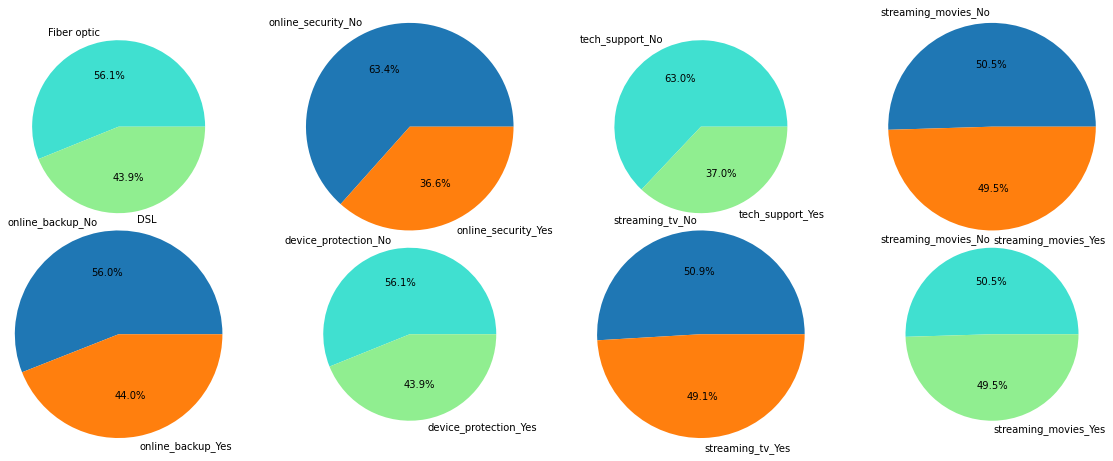

In [18]:
internet_servicel_vc = internet['InternetService'].value_counts()
online_security_vc = internet['OnlineSecurity'].value_counts()
online_backup_vc = internet['OnlineBackup'].value_counts()
device_protection_vc = internet['DeviceProtection'].value_counts() #		
tech_support_vc = internet['TechSupport'].value_counts()
streaming_tv_vc = internet['StreamingTV'].value_counts()
streaming_movies_vc = internet['StreamingMovies'].value_counts()

fig, ax = plt.subplots(2,4, figsize=(20,7))

ax[0,0].pie(internet_servicel_vc.values, labels=internet_servicel_vc.index, autopct='%1.1f%%', radius=1.25, colors=[ 'turquoise', 'lightgreen'])
ax[0,1].pie(online_security_vc.values, labels='online_security_'+online_security_vc.index, autopct='%1.1f%%', radius=1.5)

ax[1,0].pie(online_backup_vc.values, labels='online_backup_'+online_backup_vc.index, autopct='%1.1f%%', radius=1.5)
ax[1,1].pie(device_protection_vc.values, labels='device_protection_'+device_protection_vc.index, autopct='%1.1f%%', radius=1.25, colors=[ 'turquoise', 'lightgreen'])

ax[0,2].pie(tech_support_vc.values, labels='tech_support_'+tech_support_vc.index, autopct='%1.1f%%', radius=1.25, colors=[ 'turquoise', 'lightgreen'])
ax[1,2].pie(streaming_tv_vc.values, labels='streaming_tv_'+streaming_tv_vc.index, autopct='%1.1f%%', radius=1.5)

ax[0,3].pie(streaming_movies_vc.values, labels='streaming_movies_'+streaming_movies_vc.index, autopct='%1.1f%%', radius=1.5)
ax[1,3].pie(streaming_movies_vc.values, labels='streaming_movies_'+streaming_movies_vc.index, autopct='%1.1f%%', radius=1.25, colors=[ 'turquoise', 'lightgreen'])

plt.show()

Услугами безопасности и техподдержки большая часть пользователей пренебрегает

In [19]:
explore_data(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


'Сводная информация:'

None

'10 строк:'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


'Столбцы:'

Index(['customerID', 'MultipleLines'], dtype='object')

'Числовое описание:'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5384-ZTTWP,No
freq,1,3390


'Сумма пропусков:'

customerID       0
MultipleLines    0
dtype: int64

'Доля пропусков:'

customerID       0.0
MultipleLines    0.0
dtype: float64

'Явные дубликаты:'

0

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

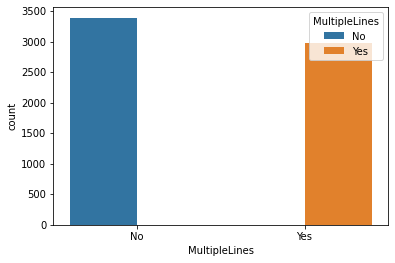

In [20]:
sns.countplot(x='MultipleLines', data=phone, hue='MultipleLines')

Пропусков и явных дубликатов нет. Количество строк в таблице меньше, чем в `contract` и `personal`. Почти половина клиентов пользуется услугами конференц связи

### Вывод
* По состоянию на 1 февраля 2020 Оператор потерял 26.5% клиентсой базы. Клиенты начали уходить в 4 квартала 2019 года 
* Большая часть ушедших клиентов платила в диапазоне 70 - 110, в то же время у действующих клиентов максимум наблюдается до 25
* Доля группы допенсионного возраста значительно превышает долю пенсионеров, аналогичная ситуация с наличием иждевенцов. Скорее всего группы с меньшими долями реже меняют оператора. Необходимо проверить, учитывая факт перехода к другому оператору
* Услугами безопасности и техподдержки большая часть пользователей пренебрегает, стриминговыми сервисами пользуется около половины клиентов
* Почти половина клиентов пользуется услугами конференц связи

 Во всех таблицах пропусков и явных дубликатов не обнаружено, в таблицах `internet` и `phone` колтчество строк меньше, чем в `contract` и `personal` - частью услуг клиенты не пользуются , для дальнейшего проведения  EDA необходимо:
 <br>
* Выполнить Замену типов данных - TotalCharges необходимо перевести в float и заменить пустые строки , BeginDate и EndDate перевести в дату
* Выполнить Обработку пропусков после объединения данных
* проверить наличие дубликатов после объединения
* проверить наличие выбросов в числовых данных
* Выполнить Кодирование категориальных признаков
* Дополнительные расчеты - на основе EndDate создать target признак, можно расчитать средний срок ухода клиента,  выделить года и месяцы, что бы определитьналичие закономерности ухода клиентов
* Выпонлнить Объединение данных без потери данных

<a id="preprocessing"></a>
## Предобработка данных

<a id="concat"></a>
### Объединение данных

In [21]:
clients = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')
clients.shape

(7043, 20)

In [22]:
explore_data(clients)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


'Сводная информация:'

None

'10 строк:'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


'Столбцы:'

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

'Числовое описание:'

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


'Сумма пропусков:'

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

'Доля пропусков:'

customerID          0.000000
BeginDate           0.000000
EndDate             0.000000
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
InternetService     0.216669
OnlineSecurity      0.216669
OnlineBackup        0.216669
DeviceProtection    0.216669
TechSupport         0.216669
StreamingTV         0.216669
StreamingMovies     0.216669
MultipleLines       0.096834
dtype: float64

'Явные дубликаты:'

0

<a id="type"></a>
### Замена типов данных

In [23]:
clients.BeginDate = pd.to_datetime(clients['BeginDate'], format='%Y-%m-%d')
clients.EndDate = pd.to_datetime(pd.to_datetime(clients['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date)

<a id="nan"></a>
### Обработка пропусков и дубликатов

In [24]:
clients[clients.TotalCharges.isna() == True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [25]:
set(clients[clients.BeginDate == '2020-02-01'].customerID) == set(clients[clients.TotalCharges.isna() == True].customerID)

True

Пустые строки толь у тех пользователей, которые появились в феврале, поэтому пропуски можно заменить на сумму месячного платежа

In [26]:
clients.loc[clients.TotalCharges.isna() == True, 'TotalCharges'] = clients[clients.TotalCharges.isna() == True].MonthlyCharges

In [27]:
clients[clients.TotalCharges.isna() == True].shape

(0, 20)

Пропуски в EndDate заменим на дату выгрузки данных '2020-02-01'

In [28]:
clients.EndDate = clients.EndDate.fillna(pd.to_datetime('2020-02-01'))

In [29]:
clients[['EndDate', 'BeginDate']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   EndDate    7043 non-null   datetime64[ns]
 1   BeginDate  7043 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 165.1 KB


Пропуски в 'InternetService' заменим на No, т.к пользователь просто не использует услугу

In [30]:
clients.loc[:, 'InternetService'::] = clients.loc[:, 'InternetService'::].fillna('No')
clients.isna().mean()

customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
MultipleLines       0.0
dtype: float64

<a id="adds"></a>
### Создание дополнительных признаков

Создадим новый признак - время жизни клиента

In [31]:
clients['duration'] = (clients.EndDate - clients.BeginDate).dt.days

In [32]:
clients[clients.EndDate == '2020-02-01'].duration.describe()

count    5174.000000
mean     1144.447236
std       733.897937
min         0.000000
25%       457.000000
50%      1157.000000
75%      1857.000000
max      2191.000000
Name: duration, dtype: float64

In [33]:
clients[clients.EndDate == '2020-02-01'].duration.median()

1157.0

In [34]:
clients[clients.EndDate != '2020-02-01'].duration.describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: duration, dtype: float64

среднее время жизни клиента у ушедших пользователей выше практически в три раза

Создадим новые признаки прользователе - 'use_internet' и 'use_phone' - пользуются ли пользователи интернетем и мобильной связью

In [35]:
clients['use_internet'] = (clients['InternetService'] != 'No').astype(int)

In [36]:
clients['use_phone'] = clients.customerID.isin(phone.customerID).astype(int)

In [37]:
clients.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,use_internet,use_phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,No,31,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,No,1036,1,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,61,1,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,No,1371,1,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,No,61,1,1


<a id="outliers"></a>
### Очистка от выбросов

во время ИАД не было выявлено выбросов, пункт нерелевантен

<a id="ohe"></a>
### Кодирование категориальных признаков


In [38]:
clients.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'duration',
       'use_internet', 'use_phone'],
      dtype='object')

Столбцы, в которых значения только yes/no закодируем  как 1/0

In [39]:
clients.InternetService.head(10)

0            DSL
1            DSL
2            DSL
3            DSL
4    Fiber optic
5    Fiber optic
6    Fiber optic
7            DSL
8    Fiber optic
9            DSL
Name: InternetService, dtype: object

In [40]:
cat_columns = ['PaperlessBilling', 'gender', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'MultipleLines']
encoder = OrdinalEncoder()
clients[cat_columns] = pd.DataFrame(encoder.fit_transform(clients[cat_columns]))

Категориальные признаки закодируем с помощью OHE

In [41]:

cats=['Type', 'PaymentMethod']
clients = pd.get_dummies(clients, columns=['Type', 'PaymentMethod'], drop_first=True)


In [42]:
clients.head()

,customerID,BeginDate,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,...,StreamingMovies,MultipleLines,duration,use_internet,use_phone,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,2020-01-01,2020-02-01,1.0,29.85,29.85,0.0,0,1.0,0.0,...,0.0,0.0,31,1,0,0,0,0,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,0.0,56.95,1889.50,1.0,0,0.0,0.0,...,0.0,0.0,1036,1,1,1,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,1.0,53.85,108.15,1.0,0,0.0,0.0,...,0.0,0.0,61,1,1,0,0,0,0,1
3,7795-CFOCW,2016-05-01,2020-02-01,0.0,42.30,1840.75,1.0,0,0.0,0.0,...,0.0,0.0,1371,1,0,1,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,1.0,70.70,151.65,0.0,0,0.0,0.0,...,0.0,0.0,61,1,1,0,0,0,1,0


<a id="target"></a>
### Формирование target-признака


In [43]:
clients['inactive'] = (clients.EndDate != '2020-02-01').astype(int)
clients.head()

,customerID,BeginDate,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,...,MultipleLines,duration,use_internet,use_phone,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,inactive
0,7590-VHVEG,2020-01-01,2020-02-01,1.0,29.85,29.85,0.0,0,1.0,0.0,...,0.0,31,1,0,0,0,0,1,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,0.0,56.95,1889.50,1.0,0,0.0,0.0,...,0.0,1036,1,1,1,0,0,0,1,0
2,3668-QPYBK,2019-10-01,2019-12-01,1.0,53.85,108.15,1.0,0,0.0,0.0,...,0.0,61,1,1,0,0,0,0,1,1
3,7795-CFOCW,2016-05-01,2020-02-01,0.0,42.30,1840.75,1.0,0,0.0,0.0,...,0.0,1371,1,0,1,0,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,1.0,70.70,151.65,0.0,0,0.0,0.0,...,0.0,61,1,1,0,0,0,1,0,1


<a id="division"></a>
### train-test разбиение


<AxesSubplot:>

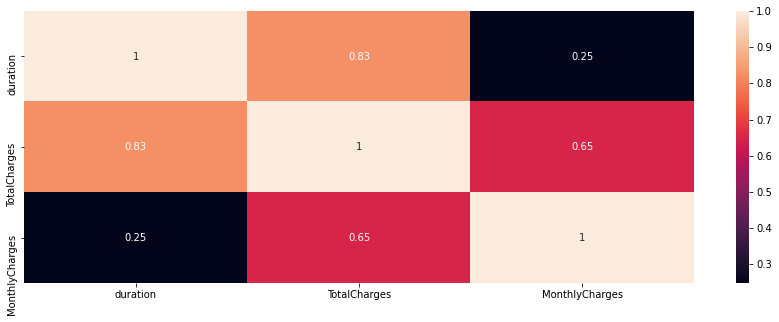

In [44]:
fig, ax = plt.subplots(figsize=(15,5))   
sns.heatmap(clients[['duration', 'TotalCharges','MonthlyCharges']].corr(), annot=True)

In [45]:
target = clients.inactive
features = clients.drop(['customerID', 'BeginDate', 'EndDate',  'inactive',  'InternetService','MonthlyCharges', 'TotalCharges' ],axis=1) #'TotalCharges','MonthlyCharges',


In [46]:
features_train, features_test, target_train,target_test = train_test_split(features,target, stratify=target, test_size=0.25, random_state=RANDOM_STATE)
print("first split: ",features_train.shape,target_train.shape,features_test.shape, target_test.shape)


first split:  (5282, 20) (5282,) (1761, 20) (1761,)


<a id="scale"></a>
### Масштабирование данных


In [47]:
pd.set_option('display.max_columns', None)

In [48]:
scaler = StandardScaler()
#scaler.fit(features_train['TotalCharges'])
#features_train.loc[:,['duration','MonthlyCharges']] = scaler.fit_transform(features_train[['duration','MonthlyCharges']])
#features_test.loc[:,['duration','MonthlyCharges']]= scaler.transform(features_test[['duration','MonthlyCharges']])
features_train.loc[:,['duration']] = scaler.fit_transform(features_train[['duration']])
features_test.loc[:,['duration']]= scaler.transform(features_test[['duration']])


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [49]:
features_test.head()

,PaperlessBilling,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,use_internet,use_phone,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4395,1.0,0.0,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.495471,1,1,0,0,0,1,0
2895,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191850,0,1,1,0,0,0,0
845,0.0,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.702635,0,1,1,0,0,0,1
806,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.579627,1,1,0,0,1,0,0
1728,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.519426,1,1,0,1,0,0,0


<a id="balanced"></a>
### Балансировка классов

Рассмотрим распределение классов в тренировочном наборе 

<AxesSubplot:title={'center':'Распределение классов тренировочного набора'}>

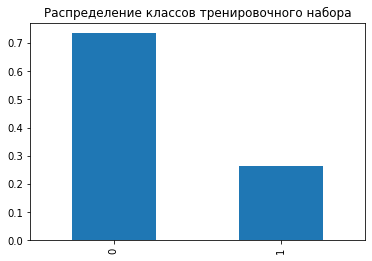

In [50]:
target_train.value_counts(normalize=True).plot(kind='bar', title='Распределение классов тренировочного набора')

Очевидно преобладание одного из классов, поэтому создадим функции для upsampling и downsampling

In [51]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

<AxesSubplot:title={'center':'Распределение классов тренировочного набора после upsampling'}>

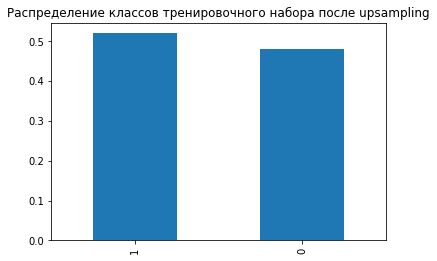

In [52]:
target_upsampled.value_counts(normalize=True).plot(kind='bar', title='Распределение классов тренировочного набора после upsampling')

In [53]:
print("features shape: ",features_upsampled.shape,"\ntarget shape: ", target_upsampled.shape)

features shape:  (8086, 20) 
target shape:  (8086,)


In [54]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.35)

<AxesSubplot:title={'center':'Распределение классов тренировочного набора после downsampling'}>

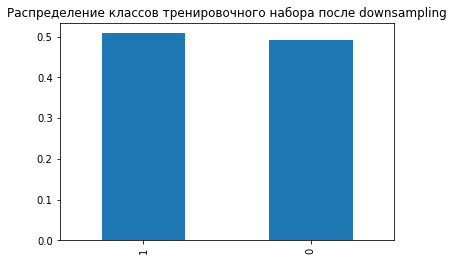

In [55]:
target_downsampled.value_counts(normalize=True).plot(kind='bar', title='Распределение классов тренировочного набора после downsampling')

In [56]:
print("features shape: ",features_downsampled.shape,"\ntarget shape: ", target_downsampled.shape)

features shape:  (2760, 20) 
target shape:  (2760,)


<a id="ml"></a>
## Моделирование

In [57]:
def best_hypers_for_model(model, hyperparams, features, target):

    clf = GridSearchCV(model, hyperparams, refit = True, scoring='roc_auc', n_jobs=-1)
    clf.fit(features, target)
    print(str(model)[:-2],"Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params']):
        print("%0.6f for %r"% (abs(mean), params))
    return clf.best_estimator_

### CatBoostClassifier

In [58]:
MODEL_SETTINGS = {
  'verbose':[False],
  'learning_rate': [ 0.5, 0.07, 0.06],
  'iterations': [1000, 2000, 1300],
  'random_state':[RANDOM_STATE],
  'max_depth': [2,4,6,8]}

In [59]:

CB = best_hypers_for_model(CatBoostClassifier(),MODEL_SETTINGS,features_train, target_train)
CB

<catboost.core.CatBoostClassifier object at 0x7febf215540 Best parameters set found on development set:

{'iterations': 1000, 'learning_rate': 0.5, 'max_depth': 2, 'random_state': 80822, 'verbose': False}

Grid scores on development set:

0.941894 for {'iterations': 1000, 'learning_rate': 0.5, 'max_depth': 2, 'random_state': 80822, 'verbose': False}
0.913821 for {'iterations': 1000, 'learning_rate': 0.5, 'max_depth': 4, 'random_state': 80822, 'verbose': False}
0.897729 for {'iterations': 1000, 'learning_rate': 0.5, 'max_depth': 6, 'random_state': 80822, 'verbose': False}
0.879862 for {'iterations': 1000, 'learning_rate': 0.5, 'max_depth': 8, 'random_state': 80822, 'verbose': False}
0.920046 for {'iterations': 1000, 'learning_rate': 0.07, 'max_depth': 2, 'random_state': 80822, 'verbose': False}
0.933486 for {'iterations': 1000, 'learning_rate': 0.07, 'max_depth': 4, 'random_state': 80822, 'verbose': False}
0.924749 for {'iterations': 1000, 'learning_rate': 0.07, 'max_depth': 6, 'random_

In [ ]:
default_cb = best_hypers_for_model(CatBoostClassifier(random_state=RANDOM_STATE),{},features_train, target_train)
default_cb

In [ ]:
default_cb.get_all_params()

In [ ]:
cat_up = best_hypers_for_model(CatBoostClassifier(),MODEL_SETTINGS,features_upsampled, target_upsampled)
cat_up

In [ ]:
best_hypers_for_model(CatBoostClassifier(),MODEL_SETTINGS,features_downsampled, target_downsampled)

### LogisticRegression()

In [127]:
MODEL_SETTINGS = {'solver':['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
                  'random_state':[RANDOM_STATE],
                 'max_iter': [1000, 5000, 10000]}
b = best_hypers_for_model(LogisticRegression(),MODEL_SETTINGS,features_train, target_train)

LogisticRegression Best parameters set found on development set:

{'max_iter': 1000, 'random_state': 80822, 'solver': 'sag'}

Grid scores on development set:

0.837954 for {'max_iter': 1000, 'random_state': 80822, 'solver': 'liblinear'}
0.837971 for {'max_iter': 1000, 'random_state': 80822, 'solver': 'newton-cg'}
0.837964 for {'max_iter': 1000, 'random_state': 80822, 'solver': 'lbfgs'}
0.837972 for {'max_iter': 1000, 'random_state': 80822, 'solver': 'sag'}
0.837969 for {'max_iter': 1000, 'random_state': 80822, 'solver': 'saga'}
0.837954 for {'max_iter': 5000, 'random_state': 80822, 'solver': 'liblinear'}
0.837971 for {'max_iter': 5000, 'random_state': 80822, 'solver': 'newton-cg'}
0.837964 for {'max_iter': 5000, 'random_state': 80822, 'solver': 'lbfgs'}
0.837972 for {'max_iter': 5000, 'random_state': 80822, 'solver': 'sag'}
0.837969 for {'max_iter': 5000, 'random_state': 80822, 'solver': 'saga'}
0.837954 for {'max_iter': 10000, 'random_state': 80822, 'solver': 'liblinear'}
0.837971 for

In [ ]:
best_hypers_for_model(LogisticRegression(),MODEL_SETTINGS,features_upsampled, target_upsampled)

In [ ]:
best_hypers_for_model(LogisticRegression(),MODEL_SETTINGS,features_downsampled, target_downsampled)

### DecisionTreeClassifier

In [126]:
MODEL_SETTINGS = {'max_depth':[x for x in range(2, 31)],
                  
                  'random_state':[RANDOM_STATE]}
best_hypers_for_model(DecisionTreeClassifier(),MODEL_SETTINGS, features_train, target_train)

DecisionTreeClassifier Best parameters set found on development set:

{'max_depth': 6, 'random_state': 80822}

Grid scores on development set:

0.739509 for {'max_depth': 2, 'random_state': 80822}
0.784422 for {'max_depth': 3, 'random_state': 80822}
0.805498 for {'max_depth': 4, 'random_state': 80822}
0.822166 for {'max_depth': 5, 'random_state': 80822}
0.829181 for {'max_depth': 6, 'random_state': 80822}
0.826419 for {'max_depth': 7, 'random_state': 80822}
0.818589 for {'max_depth': 8, 'random_state': 80822}
0.808808 for {'max_depth': 9, 'random_state': 80822}
0.796795 for {'max_depth': 10, 'random_state': 80822}
0.784908 for {'max_depth': 11, 'random_state': 80822}
0.768795 for {'max_depth': 12, 'random_state': 80822}
0.751771 for {'max_depth': 13, 'random_state': 80822}
0.743507 for {'max_depth': 14, 'random_state': 80822}
0.729054 for {'max_depth': 15, 'random_state': 80822}
0.722125 for {'max_depth': 16, 'random_state': 80822}
0.715317 for {'max_depth': 17, 'random_state': 80822}


DecisionTreeClassifier(max_depth=6, random_state=80822)

In [ ]:

best_hypers_for_model(DecisionTreeClassifier(),MODEL_SETTINGS, features_upsampled, target_upsampled)


In [ ]:
best_hypers_for_model(DecisionTreeClassifier(),MODEL_SETTINGS, features_downsampled, target_downsampled)

### RandomForestClassifier()

In [125]:
MODEL_SETTINGS = {'max_depth':[x for x in range(2, 21)],
                  'n_estimators': [x for x in range (100,500,100)],
                  'random_state':[RANDOM_STATE]}
best_hypers_for_model(RandomForestClassifier(),MODEL_SETTINGS, features_train, target_train)

RandomForestClassifier Best parameters set found on development set:

{'max_depth': 9, 'n_estimators': 400, 'random_state': 80822}

Grid scores on development set:

0.825105 for {'max_depth': 2, 'n_estimators': 100, 'random_state': 80822}
0.824141 for {'max_depth': 2, 'n_estimators': 200, 'random_state': 80822}
0.822672 for {'max_depth': 2, 'n_estimators': 300, 'random_state': 80822}
0.824669 for {'max_depth': 2, 'n_estimators': 400, 'random_state': 80822}
0.831958 for {'max_depth': 3, 'n_estimators': 100, 'random_state': 80822}
0.831169 for {'max_depth': 3, 'n_estimators': 200, 'random_state': 80822}
0.831208 for {'max_depth': 3, 'n_estimators': 300, 'random_state': 80822}
0.832427 for {'max_depth': 3, 'n_estimators': 400, 'random_state': 80822}
0.836754 for {'max_depth': 4, 'n_estimators': 100, 'random_state': 80822}
0.837658 for {'max_depth': 4, 'n_estimators': 200, 'random_state': 80822}
0.837307 for {'max_depth': 4, 'n_estimators': 300, 'random_state': 80822}
0.838093 for {'max_de

RandomForestClassifier(max_depth=9, n_estimators=400, random_state=80822)

### GradientBoostingClassifier

In [133]:
MODEL_SETTINGS = {
  'learning_rate': [0.1, 0.5, 0.02],
  'n_estimators': [250, 100, 200],
    'random_state':[RANDOM_STATE],
  'max_depth': [x for x in range (2,16)]}
                
best_hypers_for_model(GradientBoostingClassifier(),MODEL_SETTINGS, features_train, target_train)

GradientBoostingClassifier Best parameters set found on development set:

{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 250, 'random_state': 80822}

Grid scores on development set:

0.886066 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250, 'random_state': 80822}
0.867311 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 80822}
0.879482 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'random_state': 80822}
0.897566 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'random_state': 80822}
0.879741 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 80822}
0.893565 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 80822}
0.907281 for {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250, 'random_state': 80822}
0.889701 for {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 80822}
0.903272 for {'learning_rate': 0.1, 'max_

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=250,
                           random_state=80822)

In [ ]:
best_hypers_for_model(GradientBoostingClassifier(),MODEL_SETTINGS, features_upsampled, target_upsampled)

In [ ]:
best_hypers_for_model(GradientBoostingClassifier(),MODEL_SETTINGS, features_downsampled, target_downsampled)

### LGBMClassifier

In [122]:
MODEL_SETTINGS = {
  'learning_rate': [ 0.5, 0.6, 0.05],
  'n_estimators': [ 70, 150, 200],
    'random_state':[RANDOM_STATE],
  'max_depth': [4,5, 6, 12 ]}
lgbm = best_hypers_for_model(LGBMClassifier(),MODEL_SETTINGS,features_train, target_train)
lgbm

LGBMClassifier Best parameters set found on development set:

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 150, 'random_state': 80822}

Grid scores on development set:

0.887453 for {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 70, 'random_state': 80822}
0.893544 for {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 150, 'random_state': 80822}
0.893211 for {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'random_state': 80822}
0.885603 for {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 70, 'random_state': 80822}
0.882966 for {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 150, 'random_state': 80822}
0.882758 for {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200, 'random_state': 80822}
0.883555 for {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 70, 'random_state': 80822}
0.882087 for {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 150, 'random_state': 80822}
0.880220 for {'learning_rate': 0.5, 'max_depth': 6, 'n_e

LGBMClassifier(learning_rate=0.5, max_depth=4, n_estimators=150,
               random_state=80822)

In [130]:
lgbm_up =best_hypers_for_model(LGBMClassifier(),MODEL_SETTINGS,features_upsampled, target_upsampled)

LGBMClassifier Best parameters set found on development set:

{'learning_rate': 0.8, 'max_depth': 12, 'n_estimators': 200, 'random_state': 80822}

Grid scores on development set:

0.857794 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 80822}
0.874382 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'random_state': 80822}
0.892650 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'random_state': 80822}
0.866856 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'random_state': 80822}
0.883787 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 80822}
0.905621 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 80822}
0.881558 for {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 80822}
0.902934 for {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 80822}
0.927967 for {'learning_rate': 0.1, 'max_depth': 4, 'n_

LGBMClassifier(learning_rate=0.4, max_depth=6, n_estimators=50,
               random_state=80822)

In [ ]:
best_hypers_for_model(LGBMClassifier(),MODEL_SETTINGS,features_downsampled, target_downsampled)

<a id="test"></a>
### Тестирование

In [62]:
def plot_roc(model, target, features):
    model_name = str(model).split('(')[0]
    roc_auc = roc_auc_score(target, model.predict(features))
    fpr, tpr, thresholds = roc_curve(target, model.predict_proba(features)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label= model_name + '(area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return round(roc_auc,2), accuracy_score(target, model.predict(features))

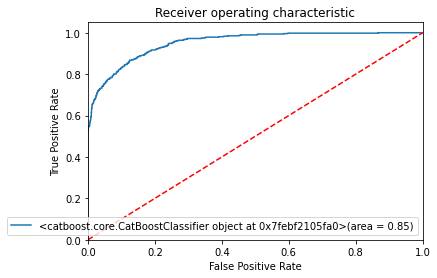

In [63]:
roc_auc, accuracy = plot_roc(CB, target_test, features_test)

In [60]:
def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + ' Feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

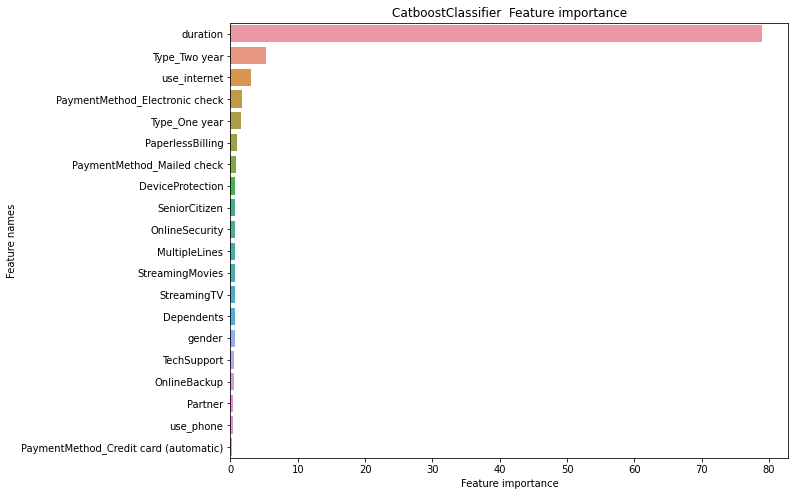

In [61]:
plot_feature_importance(CB.get_feature_importance(),features_train.columns,'CatboostClassifier ')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p>
Важные моменты для момделирования:<br>   
1) F1, Акураси и AUC - отличные метрики, но нужно держать в голове, что это лишь бобщённые характеристики. А в реальной практике бизнесу часто важно знать детали самой ошибки - из каких ошибок/успехов она складывается. И в этом случае очень кстати будут меры полноты и точности. Рассмотри возможность их использования для своих проектов. Только через них можно выйти на финансовые возможности модели. Ведь перед запуском её в бой, будет сравнение стоимости создания и поддержки модели со стомостью "оставить как есть" 
    
2) При анализе факторов влияния (их зависиомть между собой и на целевую) происходит по одному из трёх алгоритмов, исходя из типа шкалы. Могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
Это я к тому разделу, который посвящён анализу данных. Там ты сделал интересные предположения и чтобы их доказать, стои проверить аналитически. Вот как раз те методы проверки гипотез, что выше написал.<br>
    
3) Алгоритм нахождения модели может быть таким:<br>
- изучаем проблематику бизнеса и самой темы (в данном случае отток). Пытаемся понять суть явления.<br>
- генерируем разные факторы влияния - любые.<br>
- дизайнируем (прикидываем модели) какие методы решения есть, чтобы решить проблему.<br>
- Смотрим, какие данные и в какой шкале есть. Что нужно ещё, что применить выбранный метод.<br>
- Оцениваем мультиколлинеарность.<br>
- строим модели и анализируем те фактры, какие сгенерировали ранее.<br>
- Думаем над тем, какие причины (факторы) могут ещё влиять на отток.<br>
- если после нескольких итераций точность "замирает" - значит достигли потолка)<br>
 
4) Проведение анализа важности факторов с помощью команды feature_importances_ (+графический анализ). Отличная вещь намечается: высока я метрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала. Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют на уход клиента.<br><br><br>

При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы модели имеют сильную корреляцию друг с другом - больше 0.9).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее) 


<a id="conclusion"></a>
## Вывод

* Заполнены пропуски после объединения данных
* Созданы дополнительные признаки use_internet, use_phone, duration - время жизни клиента
* Сформирован целевой признак inactive
* Закодированы категориальные признаки
* Протестированы различные модели классификации: 
    * catboostClassifier,
    * decisiontreeClassifier,
    * LogisticRegressionClassifier,
    * randomForestClassifier, 
    * GradientBoostingClassifier,
    * LGBMClassifier
* протестированы методы для балансирования классов 
    * upsampling - улучшает результаты на тренировочных данных, но не помогает улучшить roc_auc на тесте
    * downsampling -  ухудшает качество
    
По итогу сравнения моделей наилучшей моделью оказалась catboostClassifier c показателями roc_auc: 0.85, accuracy: 0.9006246450880182

In [144]:
print(f'Результаты модели\n {CB.get_all_params()}:\n\n roc_auc: {roc_auc}, accuracy: {accuracy}')

Результаты модели
 {'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 80822, 'depth': 2, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.5, 'score_function': 'Cosine', 'task_ty

Судя по графику важности признаков можно сделать вывод, что наибольшую пользу приносят лишь первые 5

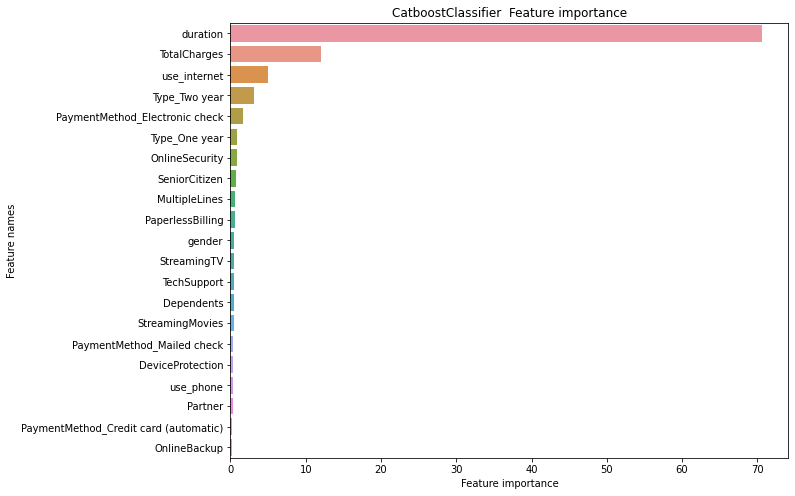

In [75]:
plot_feature_importance(CB.get_feature_importance(),features_train.columns,'CatboostClassifier ')

<div class="alert alert-info">
<b>&#129504; Комментарий студента:</b>
          Николай, добрый вечер! Спасибо за проверку!!! Спасибо за просвещение по поводу корр
</div>


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u></p>
Привет, Максим!<br>
ОК, увидел твои комментарии и изменения в проекте. ПРИНЯТО!!!!!!!!<br>
СПАСИБО за отклик!, за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>

## Отчет
1. В ходе работы были выполнены все пункты плана за исключением пункта "Очистка от выбросов". Во время проведения исследовательского анализа не было выявлено аномальных значений, поэтому указанный пункт оказался не релевантным
2. Основные трудности возникли во время подбора гиперпараметров моделей для достижения приемлемого значения метрики AUC. Процесс занимал достаточно много времени, а метрика не спешила расти))) По итогу пришлось внести корректировку в процесс предобработки данных, эксперементировать с различными наборами признаков

3. Поставленная задача была разбита на четыре основных пункта:
    1. [Иследовательский анализ данных](#eda)
    2. [Предобработка данных](#preprocessing)
    3. [Моделирование](#ml)
    4. [Выводы и рекомендации](#conclusion)
4. По итогу сравнения моделей наилучшей моделью оказалась catboostClassifier с гиперпараметрами:

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 80822, 'depth': 2, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.5, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 10, 'bootstrap_type': 'MVS', 'max_leaves': 4}:

**Результаты модели:**
 **roc_auc:** 0.85, **accuracy:** 0.9006246450880182


<div class='alert alert-success'> 👍
Спасиб за отчет, проект принят!